# Анализ событий в ClickHouse

## Введение

Этот проект посвящен анализу событий пользователей в базе данных ClickHouse. В рамках работы была создана таблица events, наполненная случайными данными (1 миллион записей) (скрипт прилагаю в README). Затем выполнен анализ данных с использованием SQL-запросов для извлечения ключевых метрик, включая вовлеченность пользователей, распределение событий, доход от покупок и другие важные показатели.

In [7]:
#экспортируем созданную таблицу events в формат csv на локальный компьютер

import clickhouse_connect
import pandas as pd
import matplotlib.pyplot as plt

# Подключаемся к ClickHouse
if __name__ == '__main__':
    client = clickhouse_connect.get_client(
        host='o4l3f0lxgn.germanywestcentral.azure.clickhouse.cloud',
        user='default',
        password='x.5oSy1a.9t7E',
        secure=True
    )

    # Выполняем запрос для получения данных из таблицы
    query = "SELECT * FROM events"
    result = client.query(query).result_set

    # Преобразуем результат в pandas DataFrame
    df = pd.DataFrame(result, columns=['event_id', 'user_id', 'event_type', 'event_timestamp', 'product_id', 'revenue'])

    # Экспортируем DataFrame в CSV на локальный компьютер
    df.to_csv('/Users/Alena/Desktop/events.csv', index=False)

    print("Данные успешно экспортированы в CSV!")


Данные успешно экспортированы в CSV!


In [14]:
#Проверяем загружаются ли экспортированные данные в csv обратно в Jupyter Notebook
df2 = pd.read_csv("/Users/Alena/Desktop/events.csv", encoding='utf-8', sep=',', parse_dates = ['event_timestamp'], dayfirst = False)
df2

,event_id,user_id,event_type,event_timestamp,product_id,revenue
0,0e389dcb-c6f4-4869-9576-0ff68a37f263,58ce0e3e-e1bc-4f3b-8984-8476ecca97bb,view,2024-09-27 13:44:38,ad656f90-7c58-464a-82a4-f13bfe50c476,0.0
1,bd1c8532-3268-429d-9c6d-a0d6fa404638,77409fef-0e58-461f-9b3b-bf7039dbcbd5,purchase,2024-09-27 13:44:41,9e5862b4-ad98-496a-988d-415366985e9d,220.0
2,266e06b8-1803-495b-b71c-fee1771ef844,16d4fb74-1dd1-490c-a672-9f227cb42d84,view,2024-09-27 13:44:42,9d99c947-5375-4d21-9002-6d1da74fd92e,0.0
3,71ab85bc-0576-491f-a584-8d2aedde3ad5,203745ff-d27e-41a4-ac82-a42595a4bce1,click,2024-09-27 13:44:43,685c9dd9-83b7-4443-8adb-142e954eb9a5,0.0
4,d5cf24a1-5c48-4bd9-ae66-1179a160b886,cd6ee66e-f40c-4eba-9197-688a597d62a7,click,2024-09-27 13:44:51,3b0df028-5e62-4d77-bb53-e742f0262088,0.0
...,...,...,...,...,...,...
999995,2779d3a6-829f-47b0-b3bb-4e7c752b378d,75ebccfb-7ec7-4e2c-9daa-8d11b2ef821f,purchase,2025-01-25 13:43:53,a7ddbace-5c7c-4d6c-bbc2-e3b5a4234fd6,675.0
999996,1349fd03-3caf-47ca-b9a7-af249efd3b11,aeb8dbcb-8dbe-4c92-af6d-cbc99154e5d1,addToCart,2025-01-25 13:44:00,ac38643f-042a-4f90-a34e-709305067077,0.0
999997,5d7f090d-fe52-4e3a-8344-147b15777256,3360fdab-b88c-4d03-8c9c-af4965960514,click,2025-01-25 13:44:07,4b15d508-fa59-4f20-9371-43b81547a6dc,0.0
999998,f680895c-e017-4361-8f71-7702a6596daf,c426e6a7-2995-4922-8a91-62487f40b98e,click,2025-01-25 13:44:15,4c24ca2c-0876-45da-ab68-c679d9806178,0.0


In [18]:
#проверяем тип данных датафрейма
df2.dtypes

event_id                   object
user_id                    object
event_type                 object
event_timestamp    datetime64[ns]
product_id                 object
revenue                   float64
dtype: object

## Анализ пользовательского поведения

Так как моей целью является осуществление анализа данных в ClickHouse, а Python я использую с той целью, чтобы отобразить результаты скриптов, установим модуль pandasql, чтобы иметь возможность использовать синтаксис SQL:


In [25]:
!pip install pandasql

#### Запрос, который извлекает общее количество уникальных пользователей и общее количество событий за последний месяц (текущий месяц):


In [36]:
from pandasql import sqldf

query = """
SELECT 
    COUNT(DISTINCT user_id) AS unique_users,
    COUNT(DISTINCT event_id) AS total_events
FROM df2
WHERE event_timestamp >= '2025-01-01' AND event_timestamp < '2025-02-01'
"""

result = sqldf(query, locals())
print(result)

   unique_users  total_events
0         87316        205292


#### Запрос, который показывает распределение типов событий (счетчик для каждого типа события) за последний месяц (текущий месяц):


In [39]:
from pandasql import sqldf

query = """
SELECT
   event_type,
   COUNT(*) AS event_count
FROM df2
WHERE event_timestamp >= '2025-01-01' AND event_timestamp < '2025-02-01'
GROUP BY event_type
ORDER BY event_count DESC
"""

# Выполняем SQL-запрос
result = sqldf(query, locals())

# Выводим результат
print(result)


  event_type  event_count
0       view        51364
1      click        51359
2  addToCart        51300
3   purchase        51269


### Визулизация

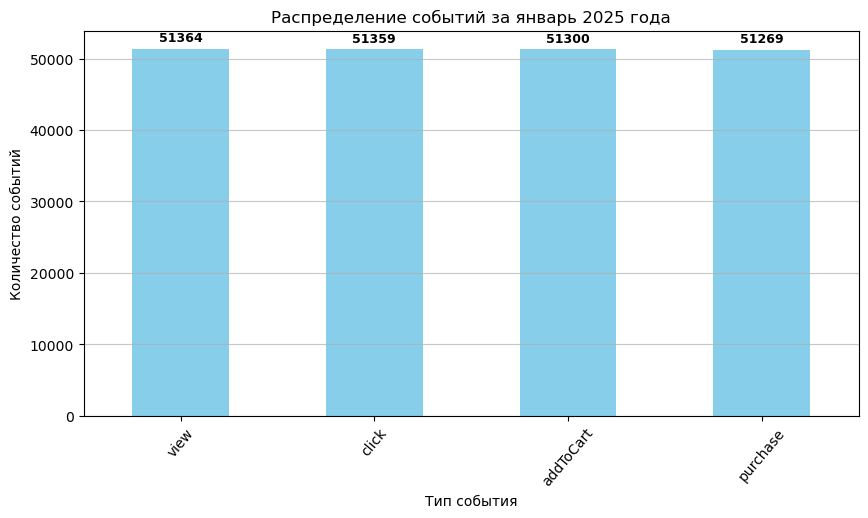

In [42]:
# Фильтруем события за январь 2025 года
df_january = df[(df['event_timestamp'] >= '2025-01-01') & (df['event_timestamp'] < '2025-02-01')]

# Группируем по event_type и считаем количество событий
event_counts = df_january['event_type'].value_counts()

# Визуализация данных
plt.figure(figsize=(10, 5))
ax = event_counts.plot(kind='bar', color='skyblue')

# Добавляем подписи (числа) над столбцами
for i, v in enumerate(event_counts):
    ax.text(i, v + max(event_counts) * 0.02, str(v), ha='center', fontsize=9, fontweight='bold')

plt.xlabel("Тип события")
plt.ylabel("Количество событий")
plt.title("Распределение событий за январь 2025 года")
plt.xticks(rotation=50)
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.show()

### Вывод:
✅ "View" (просмотр) — самое частое событие (51,364 раз), что логично, так как пользователи обычно сначала просматривают товары.

✅ "Click" (клик) — почти такое же количество (51,359 раз) — это указывает на высокую активность пользователей после просмотра.

✅ "Add to Cart" (добавление в корзину) — 51,300 раз. Количество таких событий очень близко к просмотрам и кликам, что может свидетельствовать о хорошей конверсии добавления товаров в корзину.

✅ "Purchase" (покупка) — 51,269 раз, что удивительно близко к числу добавлений в корзину. Это может указывать на очень высокий процент завершенных покупок среди тех, кто добавляет товар в корзину.


## Анализ дохода

#### Запрос, который подсчитывает общий доход от покупок (event_type = purchase) за последний месяц, а также выделяет средний доход на пользователя:


In [59]:
from pandasql import sqldf

query = """
SELECT
   SUM(revenue) AS total_revenue,
   SUM(revenue) / COUNT(DISTINCT user_id) AS avg_revenue_per_user
FROM df2
WHERE event_timestamp >= '2025-01-01'
AND event_timestamp < '2025-02-01';
"""

# Выполняем SQL-запрос
result = sqldf(query, locals())

# Выводим результат
print(result)


   total_revenue  avg_revenue_per_user
0     25978547.0            297.523329


#### Запрос для определения 5 лучших продуктов по доходу за последний месяц:


In [64]:
from pandasql import sqldf

query = """
SELECT
   product_id,
   SUM(revenue) AS total_revenue
FROM df2
WHERE event_type = 'purchase'
AND event_timestamp >= '2025-01-01'
AND event_timestamp < '2025-02-01'
GROUP BY product_id
ORDER BY total_revenue DESC
LIMIT 5;
"""

# Выполняем SQL-запрос
result = sqldf(query, locals())

# Выводим результат
print(result)


                             product_id  total_revenue
0  20e9582e-22a1-4170-b6da-ac279eeaf17c         7704.0
1  d5e68ab1-4a73-4c86-9d68-4eabfa12ed5f         7570.0
2  e8e6e4dd-1071-4170-81a2-195e9dea6f42         7489.0
3  645b7d70-505f-4861-a6f7-e1c3beb9f341         7018.0
4  d212b409-7e67-493c-870b-e0c2c6dc41a0         6892.0


## Создание нового представления


#### Запрос на создание Materialized View, который будет хранить агрегированные данные по дням: общее количество событий и общий доход от покупок.

ВАЖНО! В Python нет прямого аналога MATERIALIZED VIEW или SummingMergeTree (это специфично для ClickHouse), поэтому прикрепляю просто скрипт без вывода результата:


```
CREATE MATERIALIZED VIEW mv_daily_stats
ENGINE = SummingMergeTree()
ORDER BY event_date
AS 
SELECT
   toDate(event_timestamp) AS event_date,
   COUNT() AS total_events,
   SUMIf(revenue, event_type = 'purchase') AS total_revenue
FROM events
GROUP BY event_date;

INSERT INTO mv_daily_stats
SELECT
   toDate(event_timestamp) AS event_date,
   COUNT() AS total_events,
   SUMIf(revenue, event_type = 'purchase') AS total_revenue
FROM events
GROUP BY event_date;
```



## Оптимизация запросов 

#### Описание оптимизаций, которые можно применить к запросам, чтобы улучшить их производительность на случай, если данных станет больше (1 млрд строк).


Для работы с большими объемами данных, такими как 1 миллиард строк, можно применить следующие оптимизации для улучшения производительности ваших запросов:

#### *1. Создание дополнительных индексов (вторичных индексов) для ускорения фильтрации по event_timestamp*
В запросах активно используется фильтрация по event_timestamp (WHERE event_timestamp >= '2025-01-01' AND event_timestamp < '2025-02-01'). Однако в ClickHouse основной индекс (порядок сортировки ORDER BY event_timestamp в MergeTree) не всегда будет достаточно эффективным при увеличении данных до 1 млрд строк.

**Решение:**

Добавление гранулированного индекса (secondary index), например, используя ***SET index_granularity = 8192*** при создании таблицы или добавление индекса:

ALTER TABLE events ADD INDEX idx_event_timestamp event_timestamp TYPE minmax GRANULARITY 4;

Такой индекс позволит ClickHouse быстрее находить нужные временные интервалы, а не сканировать весь датасет.

#### Партиционирование таблицы по дате

Сейчас таблица events хранит все данные без разбиения на секции, что делает запросы с фильтрацией по event_timestamp менее эффективными.

**Решение:**

Использовать партиционирование по дате (toYYYYMM(event_timestamp)), чтобы ClickHouse мог быстро отбрасывать ненужные партиции при выполнении запроса:


```
CREATE TABLE events (
   event_id UUID,
   user_id UUID,
   event_type String,
   event_timestamp DateTime,
   product_id UUID,
   revenue Float32
) ENGINE = MergeTree()
PARTITION BY toYYYYMM(event_timestamp)  -- Разбиение по месяцам
ORDER BY (event_timestamp, user_id);
```

**Преимущества:**

✅ Ускоряет запросы с WHERE event_timestamp >= ..., так как ClickHouse будет обрабатывать только нужные партиции, а не всю таблицу.

✅ Уменьшает нагрузку на диск и оперативную память.

✅ Позволяет легко удалять старые данные (например, ALTER TABLE events DROP PARTITION '202401').

Вместо того чтобы просто увеличивать мощности, были выбраны структурные оптимизации, которые позволяют ClickHouse мгновенно обрабатывать миллиарды строк.

## Вывод

В рамках проекта была создана и проанализирована таблица событий пользователей в ClickHouse. Проведены вычисления ключевых метрик, таких как количество пользователей, распределение событий и доход. Также рассмотрены способы оптимизации запросов для работы с большими объемами данных.